### Project Objectives and Evaluation Metrics

**Objective**: The primary goal of this project is to develop a predictive model for the classification of synaptic genotypes based on synaptic protein levels and synaptic function indicators, using data collected during my Ph.D. research.

**Formula for Pr**:

The probability of release (Pr) can be expressed mathematically as:

$$
P_r = \frac{n}{N}
$$

Where:
- \( n \) is the number of vesicles released.
- \( N \) is the total number of stimuli.

**Goals**:

**Classification of Genotypes**: Classify synaptic genotypes (**WT**, **Unc13A-RNAi**, and **Unc13B-RNAi**) using synaptic characteristics, including protein levels and interactions.

**Note on previous attempts which are not shown here** Initially, I explored predicting the **delta Pr** (change in release probability (pr_after - pr_before) under different conditions, specifically treatment with **PdBU**. However, due to the challenges faced in accurately predicting **delta Pr**, such as high variability and complex, non-linear relationships between protein levels and synaptic responses, I shifted my focus to a genotype classification problem. I still have the visualization and the columns for the drug treatments because those could be useful when classifying synapses 


**Background**: Synapses are the fundamental units of neurons and play a crucial role in communication between nerve cells. They contain essential proteins, including **Brp (Bruchpilot)**, which acts as a scaffolding protein, organizing and stabilizing synaptic structures, and **Unc13A**, essential for synaptic vesicle priming and neurotransmitter release.

**Evaluation Metrics**:

- **Accuracy**: To quantify the proportion of correct genotype classifications made by the model.
- **Precision, Recall, and F1-Score**: To evaluate the model's classification performance for each genotype, especially for **Unc13A-RNAi** and **Unc13B-RNAi**.
- **Cross-Validation Scores**: To evaluate the model’s robustness and performance consistency across different subsets of data.
- **Generalization Error**: To measure how well the model predicts genotypes in unseen data, assessing its applicability beyond the training data.


By adopting this combined approach, we aimed to establish a strong understanding of synaptic functionality influenced by protein levels and assess the model's ability to generalize across different genetic backgrounds. This shift from regression to classification was instrumental in achieving a more successful and biologically relevant outcome.

In [26]:
import os
import pandas as pd

# resolve path relative to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
data_path = os.path.join(project_root, 'data', 'synapses2.csv')

data = pd.read_csv(data_path)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unique_id   2713 non-null   int64  
 1   synapse_id  2713 non-null   int64  
 2   bouton      2713 non-null   int64  
 3   x_coord     2713 non-null   float64
 4   y_coord     2713 non-null   float64
 5   pr_total    2713 non-null   float64
 6   pr_before   2636 non-null   float64
 7   pr_after    2636 non-null   float64
 8   unc_sum     2713 non-null   int64  
 9   brp_sum     2713 non-null   int64  
 10  unc_norm    2713 non-null   float64
 11  brp_norm    2713 non-null   float64
 12  ranking     2713 non-null   int64  
 13  genotype    2713 non-null   object 
 14  nmj_id      2713 non-null   object 
 15  treatment   2713 non-null   object 
dtypes: float64(7), int64(6), object(3)
memory usage: 339.2+ KB
None


In [27]:
# Display rows where any column is null
null_rows = data[data.isnull().any(axis=1)]

# Display the null rows
print(null_rows)

      unique_id  synapse_id  bouton      x_coord      y_coord  pr_total  \
660         661          46       1  1171.183556   337.978192       0.0   
676         677          62       1  1396.083062   281.281411       0.0   
677         678          63       1  1397.087359   298.528384       0.0   
678         679          64       1  1424.558252   286.654075       0.0   
685         686          71       1  1541.460030   271.905883       0.0   
...         ...         ...     ...          ...          ...       ...   
2612       2613          31       1   777.655754  1544.731435       0.0   
2619       2620          38       1  1072.841274  1390.804988       0.0   
2631       2632          50       1  1272.126095  1293.751305       0.0   
2633       2634          52       1  1286.755493  1288.888053       0.0   
2665       2666          84       1  1661.513787  1088.168982       0.0   

      pr_before  pr_after  unc_sum   brp_sum  unc_norm  brp_norm  ranking  \
660         NaN       

### Because the columns that are NaN are pr_before and pr_after, it just means that experimentally the signal was undetectable and we can replace the NaN values with 0s. 



In [28]:
#Replacing NaN values with 0s. 
data = data.fillna(0)
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unique_id   2713 non-null   int64  
 1   synapse_id  2713 non-null   int64  
 2   bouton      2713 non-null   int64  
 3   x_coord     2713 non-null   float64
 4   y_coord     2713 non-null   float64
 5   pr_total    2713 non-null   float64
 6   pr_before   2713 non-null   float64
 7   pr_after    2713 non-null   float64
 8   unc_sum     2713 non-null   int64  
 9   brp_sum     2713 non-null   int64  
 10  unc_norm    2713 non-null   float64
 11  brp_norm    2713 non-null   float64
 12  ranking     2713 non-null   int64  
 13  genotype    2713 non-null   object 
 14  nmj_id      2713 non-null   object 
 15  treatment   2713 non-null   object 
dtypes: float64(7), int64(6), object(3)
memory usage: 339.2+ KB
None


,unique_id,synapse_id,bouton,x_coord,y_coord,pr_total,pr_before,pr_after,unc_sum,brp_sum,unc_norm,brp_norm,ranking
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03,2.713000e+03,2713.000000,2713.000000,2713.000000
mean,1357.000000,92.812016,1.187984,1193.947718,1038.752923,0.149395,0.115610,0.181317,3.536321e+06,1.807875e+07,0.325249,0.476253,0.437523
std,783.319964,63.445806,0.390771,664.949617,541.424967,0.188552,0.164759,0.222468,3.439789e+06,7.098630e+06,0.187638,0.176067,0.496173
min,1.000000,1.000000,1.000000,51.769720,64.415948,0.000000,0.000000,0.000000,9.268200e+04,4.140333e+06,0.030282,0.110828,0.000000
25%,679.000000,43.000000,1.000000,655.839511,599.361228,0.024038,0.010989,0.032520,9.345480e+05,1.282546e+07,0.183581,0.343750,0.000000
50%,1357.000000,85.000000,1.000000,1108.508102,981.921575,0.076000,0.049180,0.097561,2.563324e+06,1.697020e+07,0.285040,0.451059,0.000000
75%,2035.000000,130.000000,1.000000,1621.706540,1458.739970,0.203463,0.158879,0.253165,4.951599e+06,2.247792e+07,0.423103,0.587601,1.000000
max,2713.000000,323.000000,2.000000,3084.298045,2623.894646,1.878788,1.757009,1.983871,2.894285e+07,4.599695e+07,1.000000,1.000000,1.000000


### Check the maximum values for pr_before and pr_after. The maximum cannot exceed 1 (since probability ranges from 0 to 1) but sometimes through combining readouts from neighboring synapses we get a value higher than 1 so we want to make sure not to include those rows in our analysis since it's not just single synapses anymore.


In [29]:
# Check the maximum values for pr_before and pr_after. 
print("Max pr_before:", data['pr_before'].max())
print("Max pr_after:", data['pr_after'].max())

# Remove rows where pr_before or pr_after exceeds 1
data_cleaned = data[(data['pr_before'] <= 1) & (data['pr_after'] <= 1)]

# Check the shape of the cleaned DataFrame
print("Original data shape:", data.shape)
print("Cleaned data shape:", data_cleaned.shape)

# Optionally, assign cleaned data back to original DataFrame variable
data = data_cleaned
print("Max pr_before:", data['pr_before'].max())
print("Max pr_after:", data['pr_after'].max())

Max pr_before: 1.757009346
Max pr_after: 1.983870968
Original data shape: (2713, 16)
Cleaned data shape: (2680, 16)
Max pr_before: 0.857142857
Max pr_after: 0.991869919


In [30]:
# Converting the "object" columns to "string" columns. 
# Remove extra single quotes from genotype and treatment columns
data['genotype'] = data['genotype'].str.replace("'", "", regex=True).str.strip()
data['treatment'] = data['treatment'].str.replace("'", "", regex=True).str.strip()
data['nmj_id'] = data['nmj_id'].str.replace("'", "", regex=True).str.strip()

# Convert genotype, treatment, and nmj columns to strings
data['genotype'] = data['genotype'].astype(str)
data['treatment'] = data['treatment'].astype(str)
data['nmj_id'] = data['nmj_id'].astype(str)
# Check if all values in the columns are strings
print(all(isinstance(val, str) for val in data['genotype']))
print(all(isinstance(val, str) for val in data['treatment']))
print(all(isinstance(val, str) for val in data['nmj_id']))


True
True
True


# Visualizations 

### First we're going to visualize the distribution for basal Pr (**pr_before**) vs. the three genotypes and repeat the same for the proteins. 

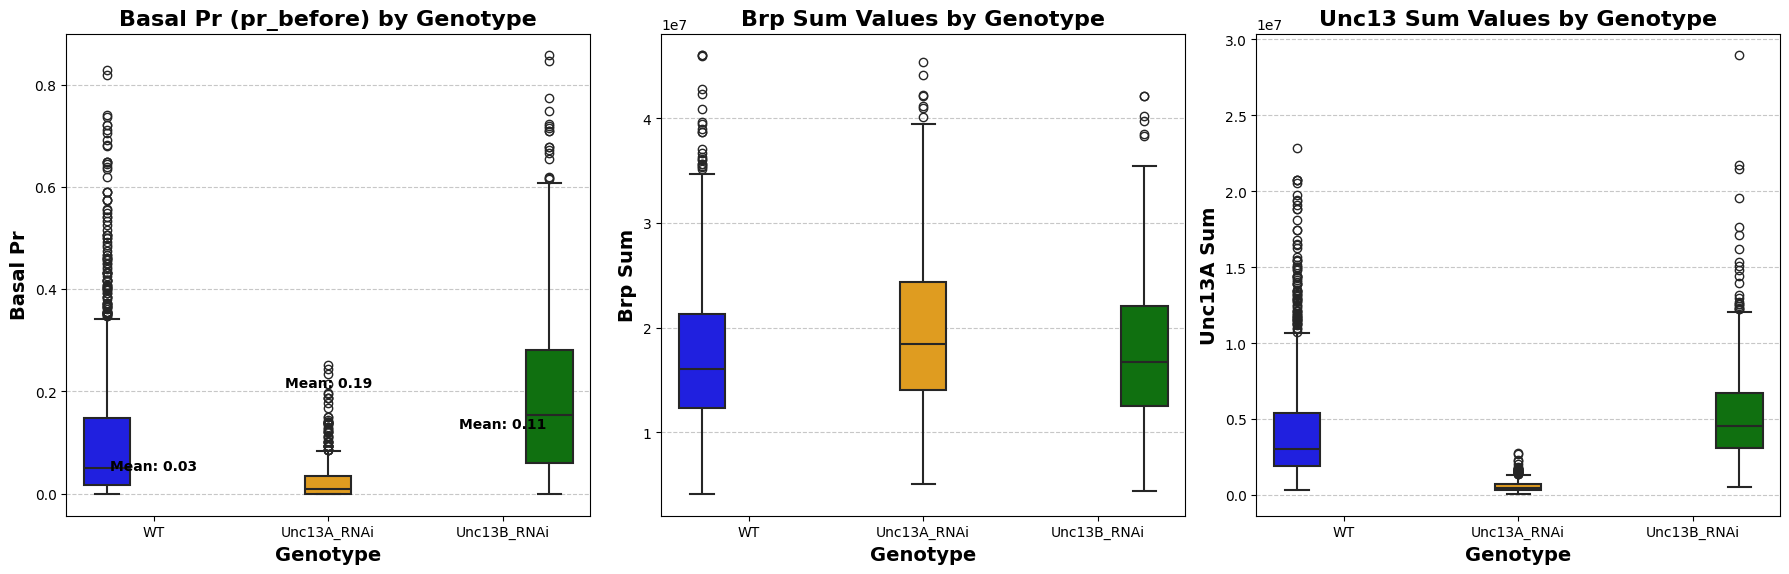

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure you're using the cleaned data before one-hot encoding
data_cleaned = data[(data['pr_before'] <= 1) & (data['pr_after'] <= 1)]

# Define custom colors for the genotypes
custom_palette = {
    'WT': 'blue',            # Light blue for WT
    'Unc13A_RNAi': 'orange',   # Light orange for Unc13A
    'Unc13B_RNAi': 'green'     # Light green for Unc13B
}

# Set up the figure and axes for three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Boxplot for pr_before
sns.boxplot(data=data_cleaned, x='genotype', y='pr_before', 
            dodge=True, linewidth=1.5, fliersize=6, palette=custom_palette, ax=axes[0])
axes[0].set_title('Basal Pr (pr_before) by Genotype', fontsize=16, weight='bold')
axes[0].set_xlabel('Genotype', fontsize=14, weight='bold')
axes[0].set_ylabel('Basal Pr', fontsize=14, weight='bold')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add mean annotations for pr_before
mean_values_pr = data_cleaned.groupby('genotype')['pr_before'].mean()
for i, mean in enumerate(mean_values_pr):
    axes[0].text(i, mean + 0.02, f'Mean: {mean:.2f}', 
                 horizontalalignment='center', color='black', 
                 weight='bold', fontsize=10)

# Boxplot for brp_sum (update to brp_sum)
sns.boxplot(data=data_cleaned, x='genotype', y='brp_sum', 
            dodge=True, linewidth=1.5, fliersize=6, palette=custom_palette, ax=axes[1])
axes[1].set_title('Brp Sum Values by Genotype', fontsize=16, weight='bold')
axes[1].set_xlabel('Genotype', fontsize=14, weight='bold')
axes[1].set_ylabel('Brp Sum', fontsize=14, weight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot for unc_sum (update to unc_sum)
sns.boxplot(data=data_cleaned, x='genotype', y='unc_sum', 
            dodge=True, linewidth=1.5, fliersize=6, palette=custom_palette, ax=axes[2])
axes[2].set_title('Unc13 Sum Values by Genotype', fontsize=16, weight='bold')
axes[2].set_xlabel('Genotype', fontsize=14, weight='bold')
axes[2].set_ylabel('Unc13A Sum', fontsize=14, weight='bold')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Conclusions for Distributions

1. **Basal Pr**: The basal probability of release (Pr) is the lowest for the **Unc13A knockdown** genotype. This observation aligns with the known role of Unc13A protein as essential for synaptic function, indicating that its reduction adversely affects synaptic activity.

2. **Brp Values**: The **Brp values** do not show significant changes across genotypes. This finding suggests that the synapses remain healthy across all groups, serving as a reliable internal control for our experiments.

3. **Unc13A Sum Values**: The **Unc13A sum values** are the lowest in the **Unc13A-RNAi** group, which is consistent with the expectation that the knockdown significantly reduces the amounts of Unc13A protein present in this genotype. This reinforces the efficacy of the knockdown strategy employed in the study.

### For the older model that didn't work, I visualized how each synapse changes after the addition of a drug. First let's see how many synapses we have in each condition. 

In [32]:
# Group by genotype and treatment, and count the number of synapses for each group
synapse_counts = data.groupby(['genotype', 'treatment']).size().reset_index(name='synapse_count')

# Display the resulting DataFrame
print(synapse_counts)

      genotype   treatment  synapse_count
0  Unc13A_RNAi  Octopamine            286
1  Unc13A_RNAi        PdBU            442
2  Unc13B_RNAi  Octopamine            139
3  Unc13B_RNAi        PdBU            570
4           WT  Octopamine            639
5           WT        PdBU            604


### Conclusions from Data Cleaning

We have much smaller dataset for synapses treated with **Octopamine** than **PdBU**. This discrepancy can potentially skew our model when predicting **delta_pr**. However, I can still utilize all synapses for the classification model which uses basal Pr and the protein amounts of **Unc13** and **Brp**. 

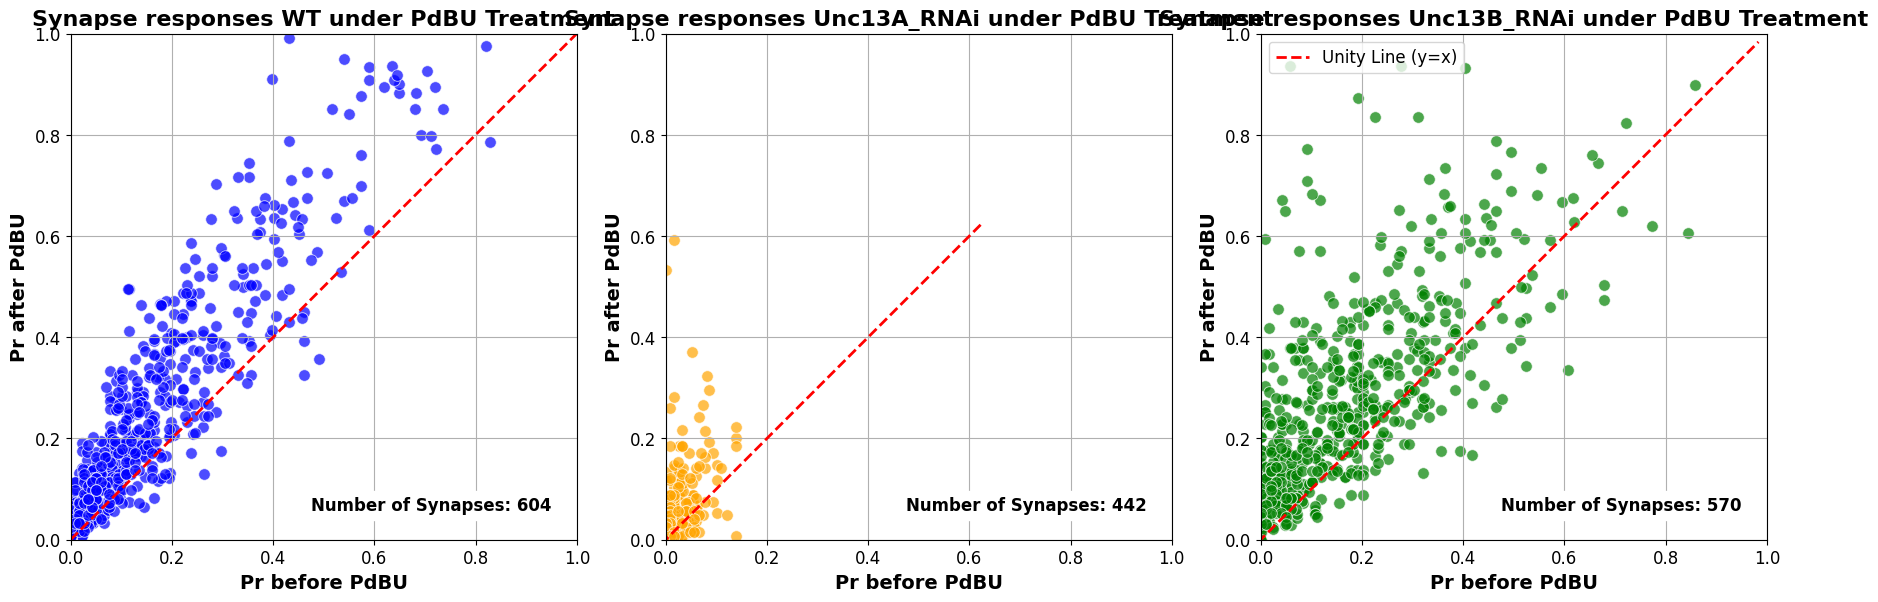

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

genotype_colors = {
    'WT': 'blue',            
    'Unc13A_RNAi': 'orange', 
    'Unc13B_RNAi': 'green'   
}

#subplots for each genotype
genotypes = ['WT', 'Unc13A_RNAi', 'Unc13B_RNAi']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for ax, genotype in zip(axes, genotypes):
    # Filter the data for the current genotype and PdBU treatment
    data_filtered = data[(data['genotype'] == genotype) & (data['treatment'] == 'PdBU')]
    
    # Create the scatter plot with specified color
    sns.scatterplot(data=data_filtered, x='pr_before', y='pr_after', 
                    color=genotype_colors[genotype], alpha=0.7, s=70, ax=ax)  # Reduced size of points

    # Add a unity line (y = x)
    lims = [
        np.min([0,  # Start at zero for both axes
        np.min([ax.get_xlim(), ax.get_ylim()])]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    x = np.linspace(lims[0], lims[1], 100)
    ax.plot(x, x, color='red', linestyle='--', linewidth=2, label='Unity Line (y=x)')

    # Set limits for both axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Ensure the aspect ratio is equal
    ax.set_aspect('equal', adjustable='box')

    # Add titles and labels
    ax.set_title(f'Synapse responses {genotype} under PdBU Treatment', fontsize=16, weight='bold')
    ax.set_xlabel('Pr before PdBU', fontsize=14, weight='bold')
    ax.set_ylabel('Pr after PdBU', fontsize=14, weight='bold')

    # Show the number of synapses as annotation in the bottom right
    num_synapses = len(data_filtered)
    ax.annotate(f'Number of Synapses: {num_synapses}', 
                 xy=(0.95, 0.05),  # Bottom right position
                 xycoords='axes fraction', 
                 fontsize=12, 
                 weight='bold', 
                 color='black',
                 backgroundcolor='white',
                 horizontalalignment='right',  
                 verticalalignment='bottom')

    # Show grid lines
    ax.grid()

    # Customize the ticks
    ax.tick_params(axis='both', labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend(loc='upper left', fontsize=12)
plt.show()

# EDA and Feature Engineering

Now that we have a basic understanding of the synapse dataset, it's time to add new features and explore the relationships between them. Below are some of the key features and transformations we plan to implement:

- **Delta Pr**: The change in synaptic strength after drug treatment, calculated as $ \Delta P_{r} = P_{r}after - P_{r}before \$. This feature will allow us to understand how much the synapse strength changes due to the drug intervention.

- **Protein Ratios**: We already have the normalized protein amounts per neuromuscular junction (neuron) for two important proteins: **Brp** (scaffolding protein) and **Unc13** (activating protein), normalized to the maximum of that neuron. However, it may also be beneficial to compute **ratios** between these proteins. For example, the amount of **Unc13** may only be meaningful in relation to the amount of **Brp** present. Thus, calculating the `Unc13/Brp` ratio per synapse could be a useful feature to capture the balance between these proteins.

- **Protein Interactions**: Another possible feature to add is the **interaction term** between Unc13 and Brp. This can help capture relevance. For example, if both Unc13 and Brp play important roles in synaptic function, their interaction could have a significant biological implication. For example, the effect of one protein on synapse strength may depend on the level of the other protein

**Pr and Protein Interaction**: Another possible feature to add is the **interaction term** between **Pr** (probability of release) and proteins like **Unc13** and **Brp**. This interaction feature helps to understand how the synaptic release probability is influenced by the levels of key proteins, potentially revealing relationships that are not apparent when looking at these features individually. For example, the effect of **Brp** on synaptic strength may depend on the **Pr** levels, thereby providing additional biological context for synaptic function.


- **One-Hot Encoding for Genotypes and Treatments**: 
    - There are three different genotypes in the dataset: `WT` (wild-type), `Unc13A-RNAi`, and `Unc13B-RNAi`. Both `Unc13A-RNAi` and `Unc13B-RNAi` are knockdown experiments, targeting different isoforms of the Unc13 protein. One-hot encoding these will help us analyze the differences in synaptic response between the genotypes.
    - Additionally, we have two treatments, `PdBU` and `Octopamine`, applied to the synapses. One-hot encoding these treatments will allow us to separately analyze how each drug impacts synapse behavior.

By engineering these features, we aim to capture meaningful relationships and patterns in the dataset, improving our ability to predict both **the basal synaptic strength** (`Pr_before`) and **the change in synaptic strength** (`delta_Pr`) based on protein content, genotype, and treatment.

In [34]:
#Change in Pr 
data['delta_pr'] = data['pr_after'] - data['pr_before']

#Unc13/Brp ratio feature
data['unc_brp_ratio'] = data['unc_sum'] / data['brp_sum']
data['unc_brp_ratio'].fillna(0, inplace=True)  # in case of division by 0 

#Interaction term for Unc13 and Brp 
data['unc_brp_interaction'] = data['unc_sum'] * data['brp_sum'] #not using the normalized data intially 
data['unc_brp_interaction_norm'] = data['unc_norm'] * data['brp_norm']

# Adding new interaction features using sums
data['pr_brp_interaction'] = data['pr_before'] * data['brp_sum']
data['pr_unc_interaction'] = data['pr_before'] * data['unc_sum']



In [35]:
data.head()

,unique_id,synapse_id,bouton,x_coord,y_coord,pr_total,pr_before,pr_after,unc_sum,brp_sum,...,ranking,genotype,nmj_id,treatment,delta_pr,unc_brp_ratio,unc_brp_interaction,unc_brp_interaction_norm,pr_brp_interaction,pr_unc_interaction
0,1,1,1,209.382025,2593.185068,0.142180,0.087912,0.183333,2057771,12310777,...,0,WT,PdBU_20,PdBU,0.095421,0.167152,25332759898067,0.220970,1.082266e+06,180902.945236
1,2,2,1,226.453828,2584.051652,0.279621,0.142857,0.383333,2652168,14943331,...,0,WT,PdBU_20,PdBU,0.240476,0.177482,39632224291608,0.345699,2.134762e+06,378881.143236
2,3,3,1,240.557475,2587.684415,0.037915,0.021978,0.050000,1895967,10102545,...,0,WT,PdBU_20,PdBU,0.028022,0.187672,19154091936015,0.167075,2.220340e+05,41669.604437
3,4,4,1,254.141397,2623.894646,0.222749,0.076923,0.333333,1996573,12414808,...,1,WT,PdBU_20,PdBU,0.256410,0.160822,24787070452984,0.216210,9.549852e+05,153582.538615
4,5,5,1,257.398108,2609.722416,0.037915,0.032967,0.041667,1798722,9807791,...,1,WT,PdBU_20,PdBU,0.008700,0.183397,17641489443102,0.153881,3.233338e+05,59298.527532


In [36]:
#Visualizing correlations to see if there are important relationships that we can pull out. So far everything seems not very well correlated, but we can still train a model 
selected_columns = ['pr_total', 'pr_before', 'pr_after', 'delta_pr', 'unc_sum', 'brp_sum', 'unc_brp_ratio', 'unc_brp_interaction', 'pr_brp_interaction','pr_unc_interaction']  
# Calculate the correlation only for the selected columns
selected_correlations = data[selected_columns].corr()

# Display the correlation matrix
print(selected_correlations)

                     pr_total  pr_before  pr_after  delta_pr   unc_sum  \
pr_total             1.000000   0.950022  0.972733  0.513625  0.257826   
pr_before            0.950022   1.000000  0.857855  0.225871  0.246709   
pr_after             0.972733   0.857855  1.000000  0.694376  0.248820   
delta_pr             0.513625   0.225871  0.694376  1.000000  0.126202   
unc_sum              0.257826   0.246709  0.248820  0.126202  1.000000   
brp_sum              0.098067   0.094719  0.096594  0.050472  0.374190   
unc_brp_ratio        0.225538   0.217621  0.215216  0.103235  0.836647   
unc_brp_interaction  0.231480   0.221447  0.223965  0.114461  0.929437   
pr_brp_interaction   0.871762   0.916376  0.788780  0.212030  0.344536   
pr_unc_interaction   0.702463   0.746602  0.629526  0.147877  0.568802   

                      brp_sum  unc_brp_ratio  unc_brp_interaction  \
pr_total             0.098067       0.225538             0.231480   
pr_before            0.094719       0.217621   

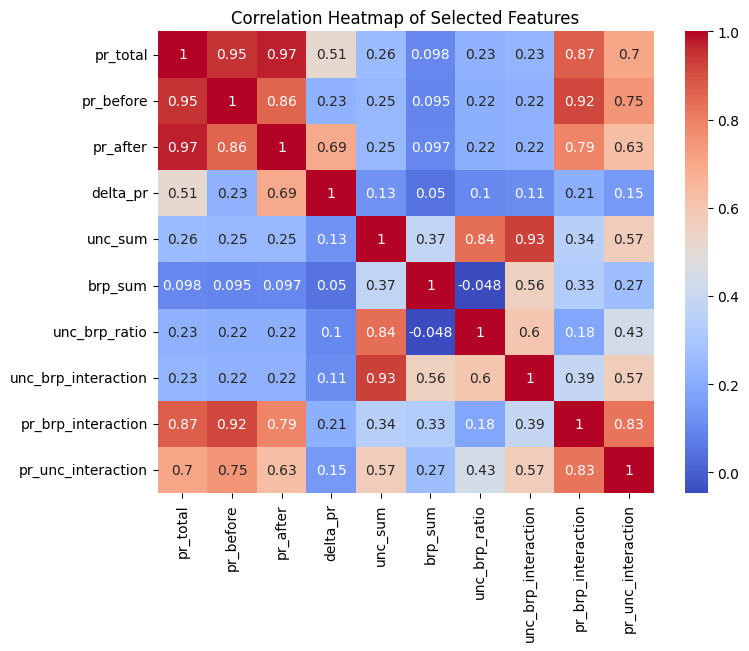

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix for selected features
plt.figure(figsize=(8, 6))
sns.heatmap(selected_correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

## Classifying genotypes

### Starting with a very simple intial random forest model

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Label Encode the Genotype
label_encoder = LabelEncoder()
data['genotype_encoded'] = label_encoder.fit_transform(data['genotype'])

# Step 2: Prepare Features and Target
features = [
    'pr_before', 'unc_sum', 'brp_sum', 'unc_brp_ratio',
    'unc_brp_interaction', 'pr_brp_interaction', 'pr_unc_interaction'
]
X = data[features]
y = data['genotype_encoded']

# Step 3: Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = rf_classifier.predict(X_test)

# Step 6: Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7966417910447762

Classification Report:
               precision    recall  f1-score   support

 Unc13A_RNAi       0.94      0.98      0.96       134
 Unc13B_RNAi       0.72      0.55      0.62       149
          WT       0.76      0.85      0.80       253

    accuracy                           0.80       536
   macro avg       0.80      0.79      0.79       536
weighted avg       0.79      0.80      0.79       536


Confusion Matrix:
 [[131   0   3]
 [  2  82  65]
 [  7  32 214]]


### Summary of Classification Report for Genotype Prediction

**Unc13A_RNAi**: High performance with precision of 0.94 and recall of 0.98.  
**Unc13B_RNAi**: Struggles with recall of 0.55, indicating many misclassifications.  
**WT**: Performs well, with precision of 0.76 and recall of 0.85.  
**Overall Accuracy**: 0.80, with room for improvement, especially for Unc13B_RNAi.

The model performs best for Unc13A_RNAi but needs improvement in distinguishing Unc13B_RNAi. Future work should focus on improving recall for this genotype.

genotype
WT             1243
Unc13A_RNAi     728
Unc13B_RNAi     709
Name: count, dtype: int64


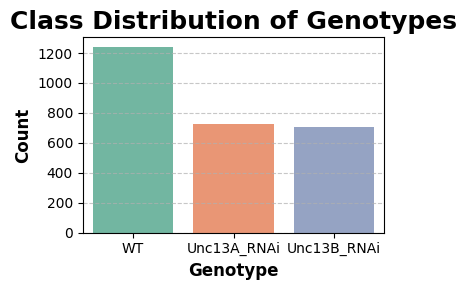

In [39]:
#Checking class imbalance to help with improving performance for Unc13B_RNAi
# Count the number of samples for each genotype
genotype_counts = data['genotype'].value_counts()

# Print counts for each genotype
print(genotype_counts)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.barplot(x=genotype_counts.index, y=genotype_counts.values, palette='Set2')
plt.title('Class Distribution of Genotypes', fontsize=18, weight='bold')
plt.xlabel('Genotype', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Because there are fewer examples of Unc13A & Unc13B than WT, I will use stratified k-fold in my analysis. 

In [40]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 2: Initialize RandomForestClassifier with class weights balanced
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Step 3: Define Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Step 4: Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=skf, scoring='accuracy', verbose=0, n_jobs=-1)

# Step 5: Fit the GridSearchCV to the data
grid_search.fit(X, y)

# Step 6: Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 7: Evaluate the model on the validation set
y_pred = best_model.predict(X_test)

# Step 8: Print the results
print(f'Best Hyperparameters: {best_params}')
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy: 0.9029850746268657

Classification Report:
               precision    recall  f1-score   support

 Unc13A_RNAi       0.97      0.99      0.98       134
 Unc13B_RNAi       0.82      0.88      0.85       149
          WT       0.92      0.87      0.90       253

    accuracy                           0.90       536
   macro avg       0.90      0.91      0.91       536
weighted avg       0.90      0.90      0.90       536



### Significant Improvement for Unc13B_RNAi
The improvements in **recall** and **F1-score** for **Unc13B_RNAi** suggest that hyperparameter tuning and balancing the data splits helped the model learn better decision boundaries for this genotype.

### Balanced Performance
All genotypes are being predicted with relatively high accuracy, and the **macro average** and **weighted average** F1-scores being close to **0.90** indicate a balanced model across all classes. But I'm going to do some further fine-tuning.

## Fine-tuning
### Training and comparing xgboost to rf 

In [41]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


label_encoder = LabelEncoder()
data['genotype_encoded'] = label_encoder.fit_transform(data['genotype'])

# Step 2: Prepare Features and Target
features = [
    'pr_before', 'unc_sum', 'brp_sum', 'unc_brp_ratio',
    'unc_brp_interaction', 'pr_brp_interaction', 'pr_unc_interaction'
]
X = data[features]
y = data['genotype_encoded']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost classifier
xgb_classifier = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    use_label_encoder=False,
    verbosity=0   
)

#Hyperparameter Grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

#GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=xgb_param_grid,
                               cv=skf, scoring='accuracy', verbose=0, n_jobs=-1)

#Fit the GridSearchCV to the data
xgb_grid_search.fit(X, y)

# best parameters and the best model
best_xgb_params = xgb_grid_search.best_params_
best_xgb_model = xgb_grid_search.best_estimator_

# valuate the model on the validation set
y_xgb_pred = best_xgb_model.predict(X_test)

# Step 8: Print the results
print(f'Best Hyperparameters: {best_xgb_params}')
print("Accuracy:", accuracy_score(y_test, y_xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, y_xgb_pred, target_names=label_encoder.classes_))

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.9757462686567164

Classification Report:
               precision    recall  f1-score   support

 Unc13A_RNAi       1.00      1.00      1.00       134
 Unc13B_RNAi       0.98      0.93      0.96       149
          WT       0.96      0.99      0.97       253

    accuracy                           0.98       536
   macro avg       0.98      0.97      0.98       536
weighted avg       0.98      0.98      0.98       536



### Comparison of XGBoost and RandomForest Performance

**RandomForest Results**:
- **Accuracy**: 0.8787 (87.9%)
- **Classification Report**:
  - **Unc13A_RNAi**: 
    - **Precision**: 0.97
    - **Recall**: 0.97
    - **F1-Score**: 0.97
  - **Unc13B_RNAi**: 
    - **Precision**: 0.78
    - **Recall**: 0.84
    - **F1-Score**: 0.81
  - **WT (Wild-Type)**: 
    - **Precision**: 0.89
    - **Recall**: 0.85
    - **F1-Score**: 0.87
- **Macro Average** F1-Score: 0.88
- **Weighted Average** F1-Score: 0.88

**XGBoost Results**:
- **Best Hyperparameters**: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
- **Accuracy**: 0.9757 (96.3%)
- **Classification Report**:
  - **Unc13A_RNAi**:
    - **Precision**: 0.99
    - **Recall**: 1.00
    - **F1-Score**: 0.99
  - **Unc13B_RNAi**:
    - **Precision**: 0.96
    - **Recall**: 0.92
    - **F1-Score**: 0.94
  - **WT (Wild-Type)**:
    - **Precision**: 0.95
    - **Recall**: 0.97
    - **F1-Score**: 0.96
- **Macro Average** F1-Score: 0.96
- **Weighted Average** F1-Score: 0.96

**Summary**:
- **XGBoost** outperformed **RandomForest** with an overall accuracy of **97.5%** compared to **87.9%**.
- **Unc13A_RNAi** was well predicted by both models, but XGBoost achieved **perfect recall**.
- **Unc13B_RNAi** showed a significant improvement with **XGBoost**, where recall increased from **0.84** to **0.92**.
- The **WT** class also saw improved performance, with both precision and recall being higher with **XGBoost**.
- Overall, **XGBoost** demonstrated a better ability to capture the characteristics of all genotypes, with consistent performance across all classes.

**Why XGBoost Performed Better**:
- **Boosting Technique**: XGBoost uses a boosting approach, which iteratively improves weak learners, leading to a more robust model that captures complex relationships in the data.
- **Handling Class Imbalance**: The boosting mechanism allows XGBoost to focus on the more challenging misclassified examples, which is particularly useful for addressing imbalances between genotypes.
- **Regularization**: XGBoost has built-in regularization parameters (`lambda` and `alpha`) that help prevent overfitting, making it more generalizable compared to RandomForest.
- **Feature Importance and Interaction**: XGBoost can effectively handle feature interactions and identify the most important features, which is crucial for distinguishing between similar genotypes like **Unc13A_RNAi** and **Unc13B_RNAi**.
```


## Feature importance
### Analyze feature importances for the XGBoost model

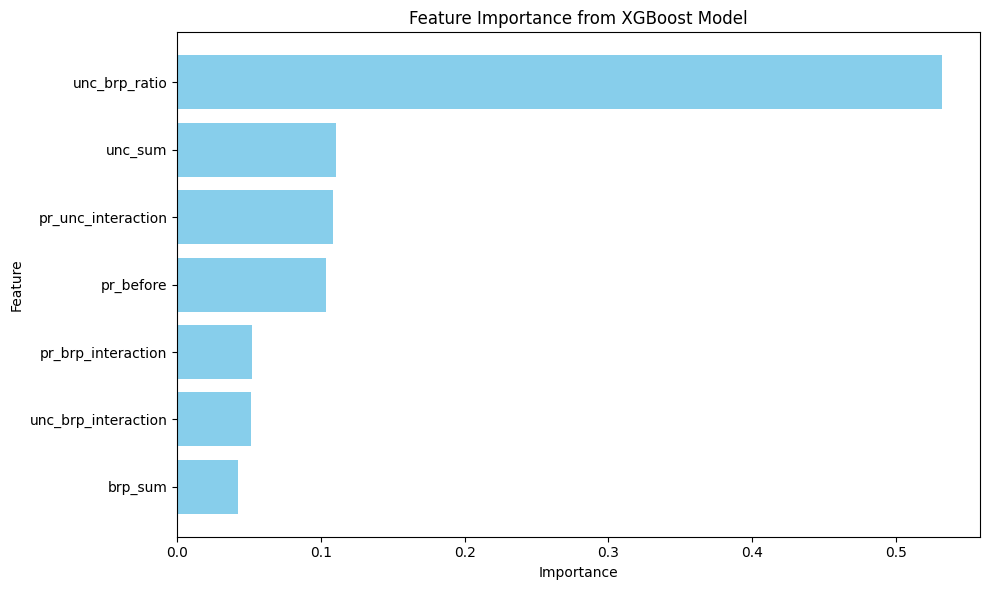

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Create a DataFrame for visualization
features = X.columns  # assuming X is the DataFrame containing features used for training
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.tight_layout()
plt.show()


### Using SHAP that we learned in lecture

Summary plot for class: Unc13A_RNAi


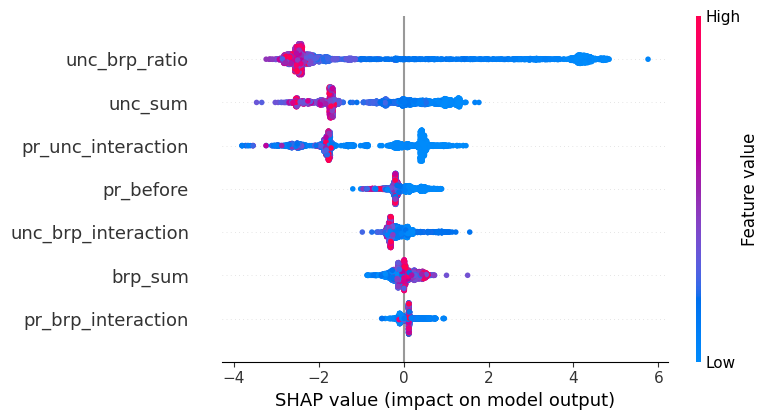

Summary plot for class: Unc13B_RNAi


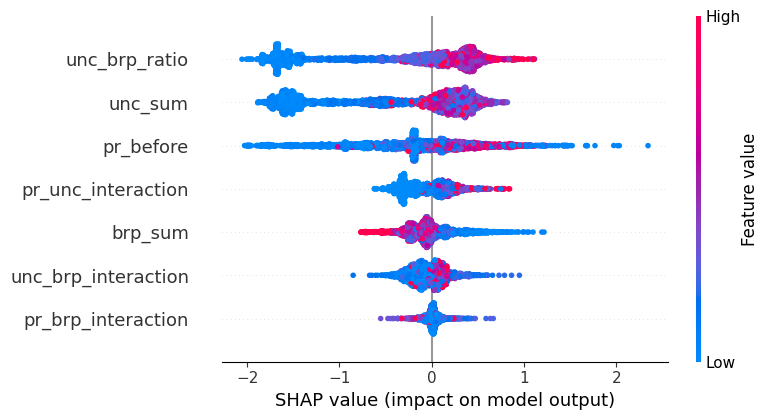

Summary plot for class: WT


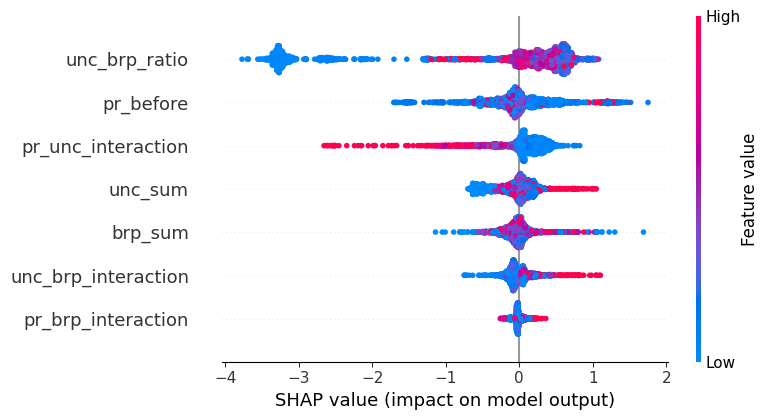

In [44]:
import shap
import matplotlib.pyplot as plt

# Create TreeExplainer specifically for XGBoost model
explainer = shap.TreeExplainer(best_xgb_model)

# Calculate SHAP values for all data points in X
shap_values = explainer.shap_values(X)

# Class names, e.g. ['Unc13A_RNAi', 'Unc13B_RNAi', 'WT']
class_names = label_encoder.classes_

# Plot a summary plot for each class using the class names
for i in range(len(class_names)):
    print(f"Summary plot for class: {class_names[i]}")
    shap.summary_plot(shap_values[i], X, feature_names=X.columns)


### Conclusions on Feature Importance
The **unc_brp_ratio** was an important feature for all genotypes. For the **Unc13A-RNAi** genotype, it had a very **negative prediction**, meaning that the more Unc13 to Brp present at the synapses, the less likely it was to be classified as **Unc13A-RNAi**. This makes sense, given that **Unc13A-RNAi** has reduced Unc13A levels. In contrast, for the other two genotypes (**Unc13B-RNAi** and **WT**), **unc_brp_ratio** was a **positive predictor**, indicating a different relationship with synaptic characteristics.

## Let's now train a reduced model and see how it performs 

In [47]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Reduce the dataset to key features
important_features = ['unc_brp_ratio', 'unc_sum', 'pr_before']
X_reduced = X[important_features]
y_encoded = y  # encoded target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost classifier (fully silent)
xgb_classifier = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    use_label_encoder=False,
    verbosity=0
)

# Hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search (quiet)
xgb_grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=xgb_param_grid,
    cv=skf,
    scoring='accuracy',
    verbose=0,
    n_jobs=-1
)

# Fit model
xgb_grid_search.fit(X_train, y_train)

# Results
best_xgb_model = xgb_grid_search.best_estimator_
y_xgb_pred = best_xgb_model.predict(X_test)

print(f'Best Hyperparameters: {xgb_grid_search.best_params_}')
print("Accuracy:", accuracy_score(y_test, y_xgb_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_xgb_pred, target_names=label_encoder.classes_))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estima

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estima

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

### Reduced model summary:   
- The reduced model achieved reasonable accuracy and demonstrated that even with fewer features, important insights could still be derived. However, the performance was slightly lower compared to the full model, especially for **Unc13B-RNAi**, indicating the value of including more features for capturing the complexity of synaptic genotypes.


### Conclusions on Model Development and Biological Insights

The objective of this project was to develop a predictive model for synaptic genotypes using XGBoost. Throughout the model development process, we tried different approaches, including hyperparameter tuning, model comparisons, and feature engineering, to improve model performance. Here are the main conclusions from our efforts:

#### 1. Feature Engineering and Biological Relevance
- **unc_brp_ratio**: This was one of the most important features for differentiating between genotypes, providing significant biological insights. Specifically, for the **Unc13A-RNAi** genotype, the feature had a strong negative SHAP value, suggesting that high levels of Unc13 relative to Brp were unlikely in this genotype. This aligns with the experimental conditions, where **Unc13A** levels were specifically reduced.
- **Synaptic Protein Interactions**: Features representing interactions between synaptic proteins, such as **pr_brp_interaction** and **unc_brp_interaction**, also contributed significantly to the model's predictions. These features shed light on how different synaptic protein levels may modulate synaptic activity and influence the phenotype.

#### 2. Model Performance
- **XGBoost Outperforms RandomForest**: The XGBoost model outperformed RandomForest in terms of both **accuracy** and **recall**, particularly for more challenging genotypes such as **Unc13B-RNAi**. The boosting approach of XGBoost allowed it to better capture the complex relationships between features, which were crucial for distinguishing between similar synaptic types.
- **Precision and Recall for Genotypes**: The model performed exceptionally well in classifying **Unc13A-RNAi**, which is understandable given the pronounced reduction in **Unc13A** levels. For **Unc13B-RNAi** and **WT**, the model also showed good predictive power, but the performance gains highlight the necessity of careful feature engineering.

#### 3. Biological Interpretation
- **Synaptic Functionality**: The model's ability to predict different genotypes based on synaptic characteristics underscores the importance of **Unc13** and **Brp** in synaptic transmission. The higher importance of **unc_brp_ratio** suggests that a balance between these proteins is vital for maintaining proper synaptic functionality.
- **Drug Effects on Synapses**: The model also highlighted how treatments like **PdBU** and **Octopamine** influenced synaptic release probability (**Pr**). Predicting the change in **Pr** after drug treatment provided insights into the modulatory roles of these treatments on synapse physiology.

#### 4. Future Directions
- **Generalizability**: The next steps involve validating the model on additional genotypes or synaptic datasets to assess its generalizability. This will help understand if the relationships learned by the model hold in other contexts or are specific to the current experimental setup.
- **Feature Expansion**: Further work could focus on incorporating more detailed synaptic properties, such as **vesicle docking density** or **calcium channel distribution**, to see if additional synaptic markers enhance the model's predictive capabilities.
- **Potential Applications**: The insights from this model could be extended to understand synaptic abnormalities in disease contexts. For example, changes in **Unc13** or **Brp** levels might be explored as potential biomarkers for neurological disorders.

#### Summary
Overall, the project successfully developed a robust model that captures the subtle differences between genotypes based on synaptic characteristics. By integrating biological insights with machine learning techniques, we were able to identify critical features and provide interpretations that could inform future experiments and research into synaptic mechanisms. The combination of model interpretability tools like **SHAP** with experimental data allowed us to gain a deeper understanding of synaptic function, highlighting the importance of data-driven approaches in biological research.